In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/clothes-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/ef8d972e-d971-48d4-85b0-ca34297e6f3e.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_self_service_25_1697102647_2c6e43da_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/mackintosh_philosophy_dress_1697107181_db88f460_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_preloved_1697093176_9e6c7446_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_broken_white_1697080948_214d020a_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_preloved_1697087061_33470d8b_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_kaftan_gamis_longdress_1697101483_33485774_progressive_thumbnail.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dd262e49-9475-442f-aa1a-7eb21747ca24.jpg
/kaggle/input/clothes-dataset/Clothes_Dataset/Gaun/dress_preloved_1697096936_67aa608d_progressive_thumbnai

In [2]:
!pip install evaluate
import evaluate # for evaluating functions
print(evaluate.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
0.4.3


In [3]:
import gc # garbage collection
import numpy as np
import pandas as pd
import itertools # for iterators and looping
from collections import Counter

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             f1_score)

In [5]:
from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from transformers import (TrainingArguments,
                          Trainer,
                          ViTImageProcessor,
                          ViTForImageClassification,
                          DefaultDataCollator
)

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop,Compose,Normalize,RandomRotation,RandomResizedCrop,RandomHorizontalFlip,RandomAdjustSharpness,Resize,ToTensor)

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
image_dict = {}

from pathlib import Path
from tqdm import tqdm 
import os

file_names = []
labels = []


In [9]:
label_dict = {
    "Blazer": "Blazer",
    "Celana_Panjang": "Long Pants",
    "Celana_Pendek": "Shorts",
    "Gaun": "Dresses",
    "Hoodie": "Hoodie",
    "Jaket": "Jacket",
    "Jaket_Denim": "Denim Jacket",
    "Jaket_Olahraga": "Sports Jacket",
    "Jeans": "Jeans",
    "Kaos": "T-shirt",
    "Kemeja": "Shirt",
    "Mantel": "Coat",
    "Polo": "Polo",
    "Rok": "Skirt",
    "Sweter": "Sweater",
}

In [10]:
for file in tqdm(sorted((Path('/kaggle/input/clothes-dataset/Clothes_Dataset/').glob('*/*.*')))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label_dict[label])  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list


print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

100%|██████████| 7500/7500 [00:00<00:00, 416757.59it/s]

7500 7500
(7500, 2)


In [11]:
df.head()

,image,label
0,/kaggle/input/clothes-dataset/Clothes_Dataset/...,Blazer
1,/kaggle/input/clothes-dataset/Clothes_Dataset/...,Blazer
2,/kaggle/input/clothes-dataset/Clothes_Dataset/...,Blazer
3,/kaggle/input/clothes-dataset/Clothes_Dataset/...,Blazer
4,/kaggle/input/clothes-dataset/Clothes_Dataset/...,Blazer


In [12]:
df["label"].value_counts()

label
Blazer           500
Long Pants       500
Shorts           500
Dresses          500
Hoodie           500
Jacket           500
Denim Jacket     500
Sports Jacket    500
Jeans            500
T-shirt          500
Shirt            500
Coat             500
Polo             500
Skirt            500
Sweater          500
Name: count, dtype: int64

In [13]:
from datasets import Dataset
from datasets import Image
dataset = Dataset.from_pandas(df).cast_column("image",Image())

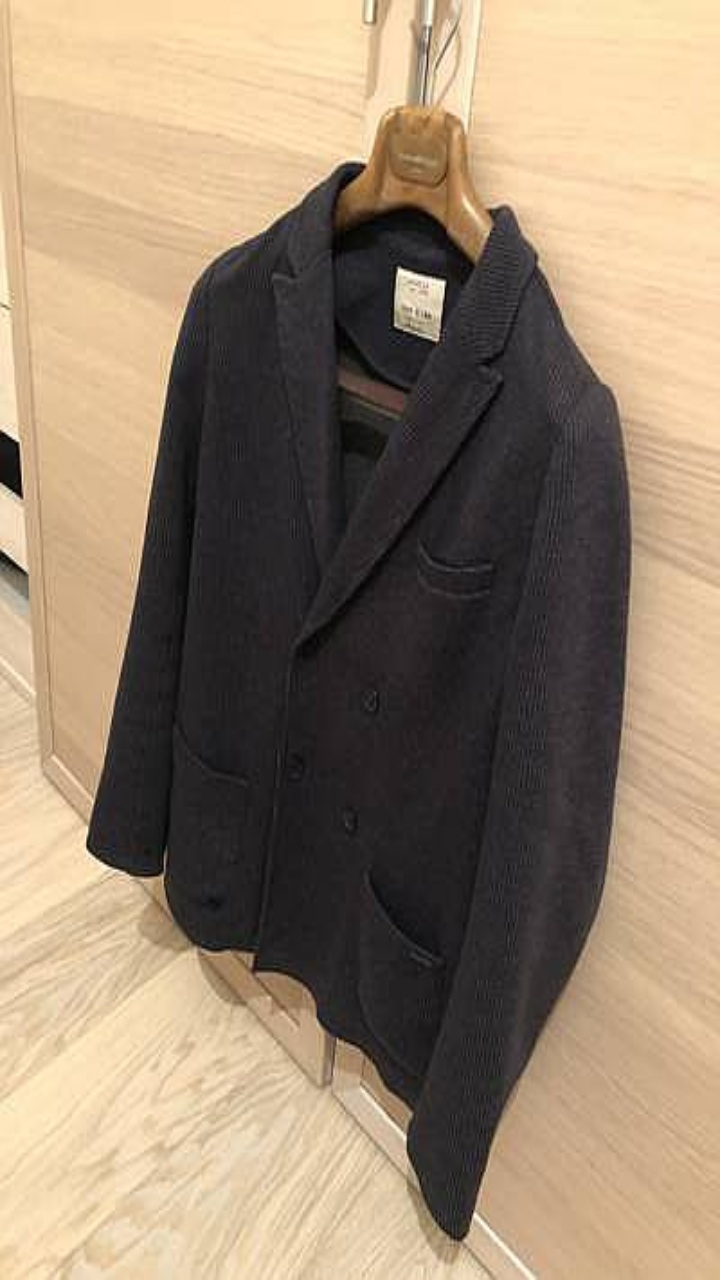

In [14]:
dataset[50]["image"]

In [15]:
labels_subset = labels[:5]
print(labels_subset)

['Blazer', 'Blazer', 'Blazer', 'Blazer', 'Blazer']


In [16]:
labels_list = sorted(list(set(labels)))

In [17]:
label2id, id2label = dict(),dict()

for i,label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label)
print(label2id)

{0: 'Blazer', 1: 'Coat', 2: 'Denim Jacket', 3: 'Dresses', 4: 'Hoodie', 5: 'Jacket', 6: 'Jeans', 7: 'Long Pants', 8: 'Polo', 9: 'Shirt', 10: 'Shorts', 11: 'Skirt', 12: 'Sports Jacket', 13: 'Sweater', 14: 'T-shirt'}
{'Blazer': 0, 'Coat': 1, 'Denim Jacket': 2, 'Dresses': 3, 'Hoodie': 4, 'Jacket': 5, 'Jeans': 6, 'Long Pants': 7, 'Polo': 8, 'Shirt': 9, 'Shorts': 10, 'Skirt': 11, 'Sports Jacket': 12, 'Sweater': 13, 'T-shirt': 14}


In [18]:
import datasets
from datasets import ClassLabel
ClassLabels = ClassLabel(num_classes = len(labels_list),names = labels_list)
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

In [19]:
dataset = dataset.map(map_label2id, batched=True)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [20]:
dataset = dataset.cast_column('label', ClassLabels)


dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Casting the dataset:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [21]:
model_str = 'google/vit-base-patch16-224-in21k'

In [22]:
processor = ViTImageProcessor.from_pretrained(model_str)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [23]:
image_mean, image_std = processor.image_mean, processor.image_std

In [24]:
size = processor.size["height"]
print("Size: ", size)

Size:  224


In [25]:
normalize = Normalize(mean=image_mean, std=image_std)


In [26]:
_train_transformers = Compose([
    Resize((size,size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    RandomHorizontalFlip(0.5),
    ToTensor(),
    normalize
])

In [27]:
_val_transforms = Compose(
    [
        Resize((size,size)),
        ToTensor(),
        normalize
    ]
)

In [28]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transformers(image.convert("RGB")) for image in examples['image']]
    return examples

In [29]:
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [30]:
train_data.set_transform(train_transforms)

In [31]:
test_data.set_transform(val_transforms)

In [32]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [33]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model.config.id2label = id2label
model.config.label2id = label2id

In [35]:
print(model.num_parameters(only_trainable=True) / 1e6)

85.810191


In [36]:
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }

In [37]:
metric_name = "accuracy"
model_name = "clothes_image_detection"
num_train_epochs = 10
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=3e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,# it is use to prevent overfitting
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-38-9c13e1b762e1>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [39]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 2.714015245437622,
 'eval_accuracy': 0.07233333333333333,
 'eval_runtime': 76.9229,
 'eval_samples_per_second': 39.0,
 'eval_steps_per_second': 2.444}

In [40]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.688771,0.112667
2,No log,2.649584,0.200333
3,No log,2.607557,0.311000
4,No log,2.563295,0.397667
5,No log,2.523514,0.456667
6,No log,2.490482,0.509667
7,No log,2.464117,0.543333
8,2.574500,2.445119,0.562333
9,2.574500,2.433961,0.577667
10,2.574500,2.430238,0.584000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=710, training_loss=2.5268360406580106, metrics={'train_runtime': 2150.1722, 'train_samples_per_second': 20.929, 'train_steps_per_second': 0.33, 'total_flos': 3.48754583632896e+18, 'train_loss': 2.5268360406580106, 'epoch': 10.0})

In [41]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 2.4302384853363037,
 'eval_accuracy': 0.584,
 'eval_runtime': 61.3954,
 'eval_samples_per_second': 48.864,
 'eval_steps_per_second': 3.062,
 'epoch': 10.0}

In [42]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 2.4302384853363037, 'test_accuracy': 0.584, 'test_runtime': 61.6022, 'test_samples_per_second': 48.7, 'test_steps_per_second': 3.052}


Accuracy: 0.5840
F1 Score: 0.5756


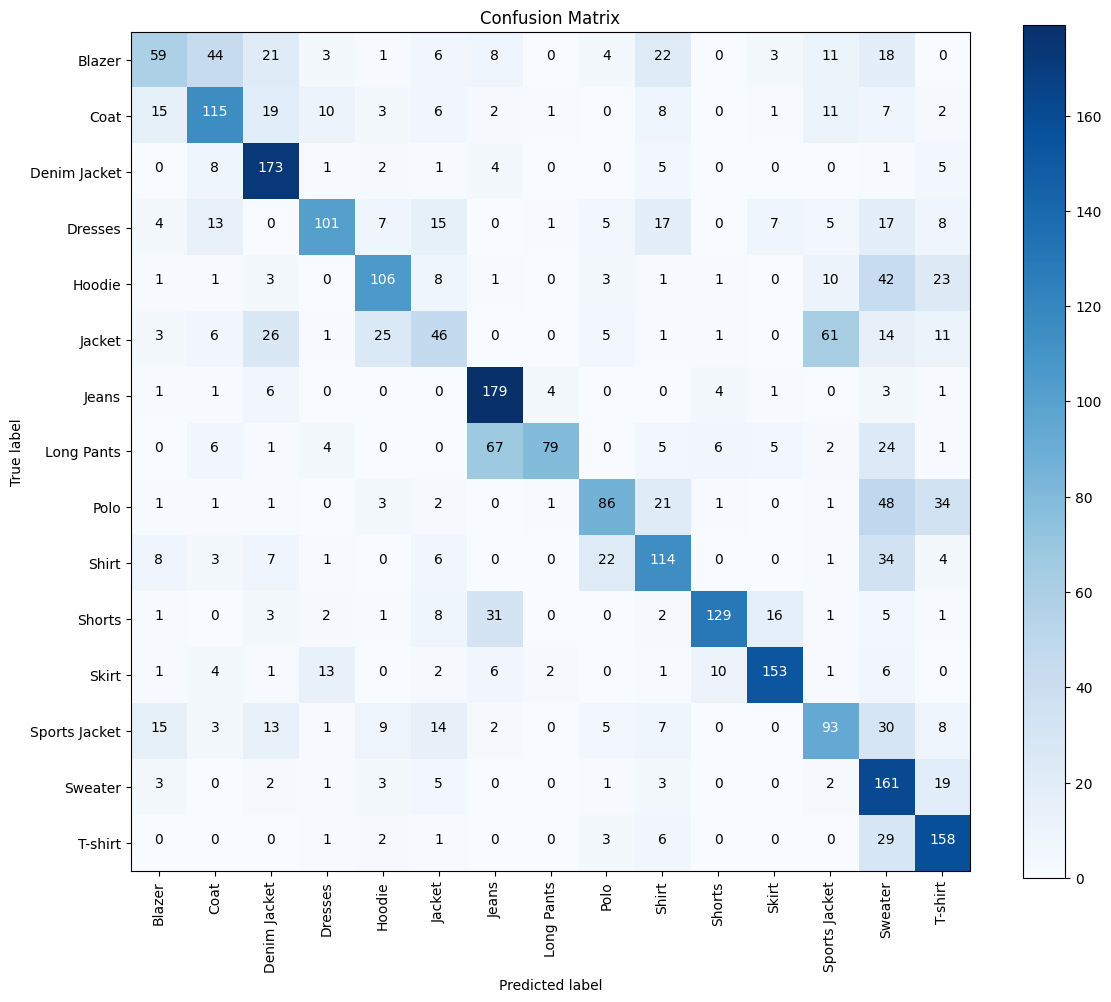


Classification report:

               precision    recall  f1-score   support

       Blazer     0.5268    0.2950    0.3782       200
         Coat     0.5610    0.5750    0.5679       200
 Denim Jacket     0.6268    0.8650    0.7269       200
      Dresses     0.7266    0.5050    0.5959       200
       Hoodie     0.6543    0.5300    0.5856       200
       Jacket     0.3833    0.2300    0.2875       200
        Jeans     0.5967    0.8950    0.7160       200
   Long Pants     0.8977    0.3950    0.5486       200
         Polo     0.6418    0.4300    0.5150       200
        Shirt     0.5352    0.5700    0.5521       200
       Shorts     0.8487    0.6450    0.7330       200
        Skirt     0.8226    0.7650    0.7927       200
Sports Jacket     0.4673    0.4650    0.4662       200
      Sweater     0.3667    0.8050    0.5039       200
      T-shirt     0.5745    0.7900    0.6653       200

     accuracy                         0.5840      3000
    macro avg     0.6153    0.5840    

In [43]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(12, 10))
    
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [44]:
trainer.save_model()

In [45]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

Device set to use cuda:0


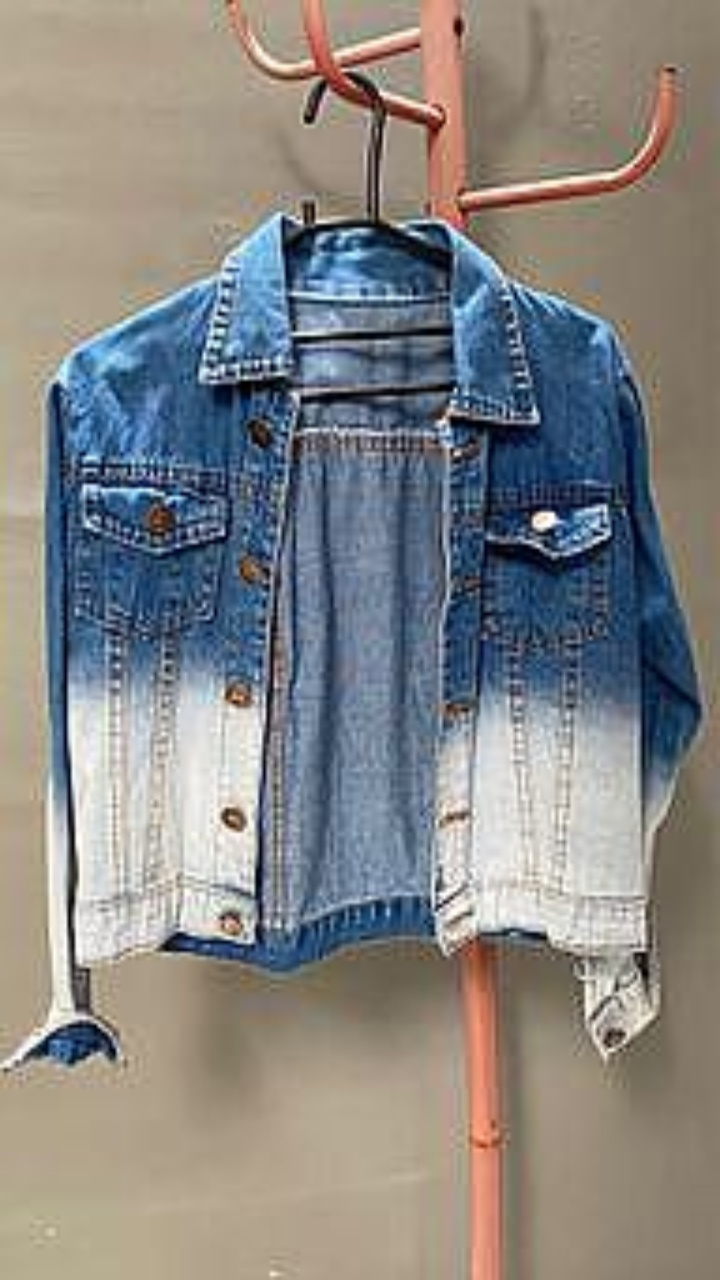

In [46]:
image = test_data[1]["image"]
image

In [47]:
pipe(image)

[{'label': 'Denim Jacket', 'score': 0.6254792809486389},
 {'label': 'Shirt', 'score': 0.5571456551551819},
 {'label': 'Sports Jacket', 'score': 0.5241682529449463},
 {'label': 'Polo', 'score': 0.5233001112937927},
 {'label': 'Jeans', 'score': 0.5214868187904358}]

In [48]:
id2label[test_data[1]["label"]]

'Denim Jacket'